<a href="https://colab.research.google.com/github/kbj1418/HAI-Assignment/blob/main/real_hai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch.utils.data as data
import glob
import PIL
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor

def getCropImg(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor()
    ])

def getLRimage(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor, PIL.Image.BICUBIC),
        Resize(crop_size, PIL.Image.BICUBIC),
        ToTensor()
    ])

class MDataset(data.Dataset):
    def __init__(self, image_dir, start, end):
        super(MDataset, self).__init__()
        self.png_files = glob.glob(image_dir + "*.png")
        self.png_files = sorted(self.png_files)
        self.png_files = self.png_files[start:end]

        self.input_transform = getLRimage(64, 2)
        self.target_transform = getCropImg(64)

    def __getitem__(self, index):
        input = PIL.Image.open(self.png_files[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return input, target

    def __len__(self):
        return len(self.png_files)


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 압축 해제 후 경로 지정
image_dir = "/content/drive/MyDrive/DIV2K_519sampled/"
train_set = MDataset(image_dir, 0, 363)
valid_set = MDataset(image_dir, 363, 467)
test_set = MDataset(image_dir, 467, 519)


In [6]:
#데이터셋 분리되었는지 확인
print("train:", len(train_set))
print("valid:", len(valid_set))
print("test:", len(test_set))
print("First train image path:", train_set.png_files if len(train_set) > 0 else "None")


train: 363
valid: 104
test: 52
First train image path: ['/content/drive/MyDrive/DIV2K_519sampled/0001.png', '/content/drive/MyDrive/DIV2K_519sampled/0002.png', '/content/drive/MyDrive/DIV2K_519sampled/0003.png', '/content/drive/MyDrive/DIV2K_519sampled/0004.png', '/content/drive/MyDrive/DIV2K_519sampled/0005.png', '/content/drive/MyDrive/DIV2K_519sampled/0006.png', '/content/drive/MyDrive/DIV2K_519sampled/0007.png', '/content/drive/MyDrive/DIV2K_519sampled/0008.png', '/content/drive/MyDrive/DIV2K_519sampled/0009.png', '/content/drive/MyDrive/DIV2K_519sampled/0010.png', '/content/drive/MyDrive/DIV2K_519sampled/0011.png', '/content/drive/MyDrive/DIV2K_519sampled/0012.png', '/content/drive/MyDrive/DIV2K_519sampled/0013.png', '/content/drive/MyDrive/DIV2K_519sampled/0014.png', '/content/drive/MyDrive/DIV2K_519sampled/0015.png', '/content/drive/MyDrive/DIV2K_519sampled/0016.png', '/content/drive/MyDrive/DIV2K_519sampled/0017.png', '/content/drive/MyDrive/DIV2K_519sampled/0018.png', '/conten

In [9]:
#파일 경로 잘 작동하는지 확인
import glob
files = glob.glob(image_dir + "*.png")
print(f'파일 개수: {len(files)}')
print(files[:5])

파일 개수: 519
['/content/drive/MyDrive/DIV2K_519sampled/0374.png', '/content/drive/MyDrive/DIV2K_519sampled/0126.png', '/content/drive/MyDrive/DIV2K_519sampled/0437.png', '/content/drive/MyDrive/DIV2K_519sampled/0031.png', '/content/drive/MyDrive/DIV2K_519sampled/0413.png']


In [8]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


In [10]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [14]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU
model = SRCNN().to(device)


In [69]:
import torch

device = torch.device("cpu")     #맥 CPU
model = SRCNN().to(device)


In [15]:
import torch
import torch.optim as optim
import torch.nn as nn

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(valid_loader.dataset)
    print(f"Validation Loss: {val_loss:.6f}")


Epoch 1/50, Train Loss: 0.060738
Validation Loss: 0.027124
Epoch 2/50, Train Loss: 0.025869
Validation Loss: 0.020913
Epoch 3/50, Train Loss: 0.018677
Validation Loss: 0.015673
Epoch 4/50, Train Loss: 0.014240
Validation Loss: 0.011903
Epoch 5/50, Train Loss: 0.010425
Validation Loss: 0.009305
Epoch 6/50, Train Loss: 0.008371
Validation Loss: 0.007655
Epoch 7/50, Train Loss: 0.007177
Validation Loss: 0.006628
Epoch 8/50, Train Loss: 0.006391
Validation Loss: 0.005786
Epoch 9/50, Train Loss: 0.005469
Validation Loss: 0.005242
Epoch 10/50, Train Loss: 0.005124
Validation Loss: 0.004860
Epoch 11/50, Train Loss: 0.004596
Validation Loss: 0.004447
Epoch 12/50, Train Loss: 0.004238
Validation Loss: 0.004204
Epoch 13/50, Train Loss: 0.004001
Validation Loss: 0.004003
Epoch 14/50, Train Loss: 0.004124
Validation Loss: 0.004781
Epoch 15/50, Train Loss: 0.004763
Validation Loss: 0.005300
Epoch 16/50, Train Loss: 0.004176
Validation Loss: 0.003812
Epoch 17/50, Train Loss: 0.003630
Validation Loss

In [16]:
torch.save(model.state_dict(), "srcnn_checkpoint.pth")


In [17]:
model2 = SRCNN().to(device)
model2.load_state_dict(torch.load("srcnn_checkpoint.pth"))
model2.eval()


SRCNN(
  (layer1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (layer2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (layer3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [18]:
import os
from torchvision.utils import save_image

os.makedirs('./SR_outputs', exist_ok=True)
model.eval()
for idx, (inputs, targets) in enumerate(test_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    save_image(outputs.cpu(), f'./SR_outputs/img_{idx+1:03d}_SR.png')


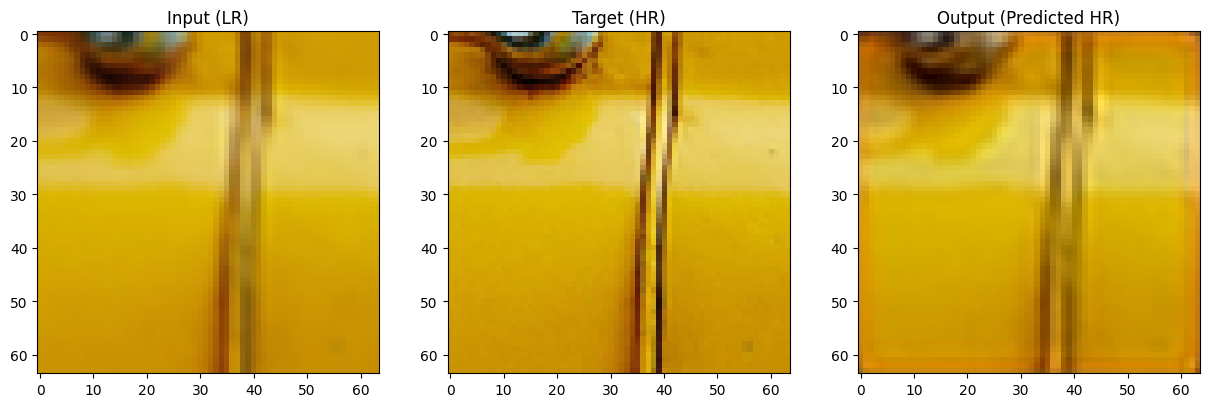

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# test_set에서 50번째 샘플 불러오기
input, target = test_set[50]

# 배치 차원 추가 후 모델에 입력, 예측값 얻기
output = model(input.unsqueeze(0).to(device))
output = output.squeeze(0).cpu().detach()
output = output.clamp(0.0, 1.0)  # 값 범위 0~1로 clamp

# 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(F.to_pil_image(input))
plt.title("Input (LR)")

plt.subplot(1, 3, 2)
plt.imshow(F.to_pil_image(target))
plt.title("Target (HR)")

plt.subplot(1, 3, 3)
plt.imshow(F.to_pil_image(output))
plt.title("Output (Predicted HR)")

plt.show()
